# Overview
The dataset of this competition contains argumentative essays written by U.S students in grades 6-12. The essays were annotated by expert raters for elements commonly found in argumentative writing. In this competition, we need to identify elements in student writing. More specifically, we need to automatically segment texts and classify argumentative and rhetorical elements in essays written by 6th-12th grade students. We have access to the largest dataset of student writing ever released to test our skills in natural language processing.
We have 15.6k writing documents to train model and train csv files containing relative information about the text files.
we have to find word sequences that can be classified as one of 7 "discourse types". These are:

* **Lead** - an introduction that begins with a statistic, a quotation, a description, or some other device to grab the reader’s attention and point toward the thesis
* **Position** - an opinion or conclusion on the main question
* **Claim** - a claim that supports the position
* **Counterclaim** - a claim that refutes another claim or gives an opposing reason to the position
* **Rebuttal** - a claim that refutes a counterclaim
* **Evidence** - ideas or examples that support claims, counterclaims, or rebuttals.
* **Concluding Statement** - a concluding statement that restates the claims

In [1]:
# required libraries
import numpy as np
import pandas as pd
import wordcloud
import glob
import spacy
from spacy import displacy
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
# train dataset
train = pd.read_csv('../input/feedback-prize-2021/train.csv')

# conevrt data type from float to int for some specific columns
train[['discourse_id', 'discourse_start', 'discourse_end']] = train[['discourse_id', 'discourse_start', 'discourse_end']].astype(int)
train.head()

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1622627660524,8,229,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1622627653021,230,312,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1622627671020,313,401,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1622627696365,402,758,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1622627759780,759,886,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...


In [3]:
# concise summary of a DataFrame.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144293 entries, 0 to 144292
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   id                  144293 non-null  object
 1   discourse_id        144293 non-null  int64 
 2   discourse_start     144293 non-null  int64 
 3   discourse_end       144293 non-null  int64 
 4   discourse_text      144293 non-null  object
 5   discourse_type      144293 non-null  object
 6   discourse_type_num  144293 non-null  object
 7   predictionstring    144293 non-null  object
dtypes: int64(3), object(5)
memory usage: 8.8+ MB


In [4]:
# Ckeck null values
train.isna().sum()

id                    0
discourse_id          0
discourse_start       0
discourse_end         0
discourse_text        0
discourse_type        0
discourse_type_num    0
predictionstring      0
dtype: int64

In [5]:
train_files = glob.glob('../input/feedback-prize-2021/train/*.txt') 
test_files = glob.glob('../input/feedback-prize-2021/test/*.txt')

print("Total number of train files: " , len(train_files))
print("Total number of test files: " , len(test_files))

Total number of train files:  15594
Total number of test files:  5


In [6]:
# a train file sample
!cat ../input/feedback-prize-2021/train/423A1CA112E2.txt

Phones

Modern humans today are always on their phone. They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media. They even do it while driving. They are some really bad consequences when stuff happens when it comes to a phone. Some certain areas in the United States ban phones from class rooms just because of it.

When people have phones, they know about certain apps that they have .Apps like Facebook Twitter Instagram and Snapchat. So like if a friend moves away and you want to be in contact you can still be in contact by posting videos or text messages. People always have different ways how to communicate with a phone. Phones have changed due to our generation.

Driving is one of the way how to get around. People always be on their phones while doing it. Which can cause serious Problems. That's why there's a thing that's called no texting while driving. That's a really important thing to remember. S

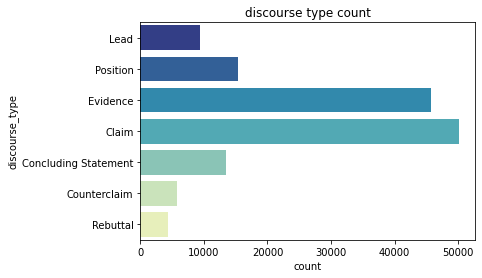

In [7]:
sns.countplot(y = 'discourse_type', data = train, palette = 'YlGnBu_r')
plt.title("discourse type count");

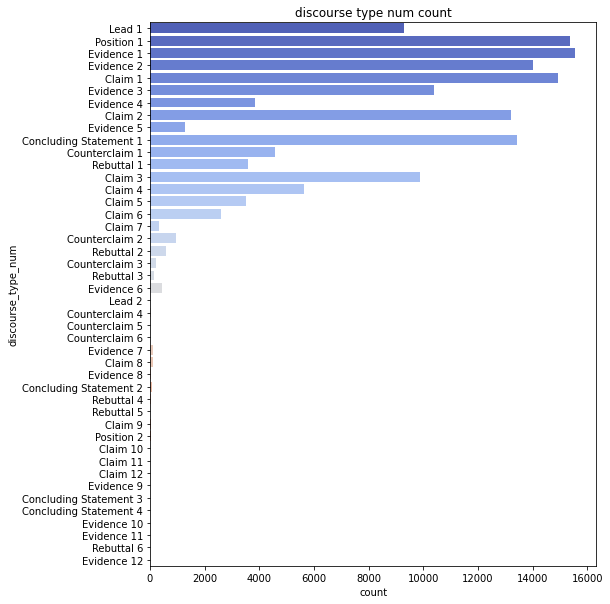

In [8]:
plt.figure(figsize=(8,10))
sns.countplot(y = 'discourse_type_num', data = train, palette = 'coolwarm')
plt.title("discourse type num count");

# Discourse Length

In [9]:
# new column contain discourse length
train["discourse_len"] = train["discourse_end"] - train["discourse_start"]

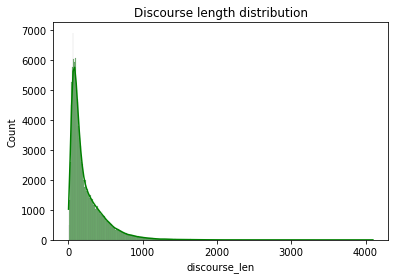

In [10]:
sns.histplot(x = 'discourse_len', data = train, kde = True, color = 'green')
plt.title("Discourse length distribution");

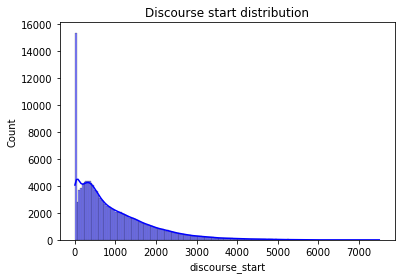

In [11]:
sns.histplot(x = 'discourse_start', data = train, kde = True, color = 'blue')
plt.title("Discourse start distribution");

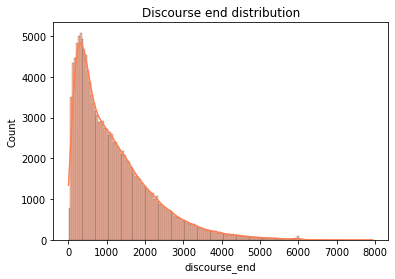

In [12]:
sns.histplot(x = 'discourse_end', data = train, kde = True, color = 'coral')
plt.title('Discourse end distribution');

# Detail for specific id

In [13]:
# as dataframe
train.query('id == "423A1CA112E2"')

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,discourse_len
0,423A1CA112E2,1622627660524,8,229,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,221
1,423A1CA112E2,1622627653021,230,312,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59,82
2,423A1CA112E2,1622627671020,313,401,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75,88
3,423A1CA112E2,1622627696365,402,758,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...,356
4,423A1CA112E2,1622627759780,759,886,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...,127
5,423A1CA112E2,1622627780655,887,1150,That's why there's a thing that's called no te...,Evidence,Evidence 3,163 164 165 166 167 168 169 170 171 172 173 17...,263
6,423A1CA112E2,1622627811787,1151,1533,Sometimes on the news there is either an accid...,Evidence,Evidence 4,211 212 213 214 215 216 217 218 219 220 221 22...,382
7,423A1CA112E2,1622627585180,1534,1602,Phones are fine to use and it's also the best ...,Claim,Claim 2,282 283 284 285 286 287 288 289 290 291 292 29...,68
8,423A1CA112E2,1622627895668,1603,1890,If you go through a problem and you can't find...,Evidence,Evidence 5,297 298 299 300 301 302 303 304 305 306 307 30...,287
9,423A1CA112E2,1622627628524,1891,2027,The news always updated when people do somethi...,Concluding Statement,Concluding Statement 1,355 356 357 358 359 360 361 362 363 364 365 36...,136


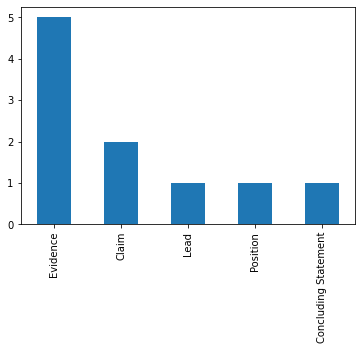

In [14]:
# discourse_type for the specific id
train.query('id == "423A1CA112E2"')["discourse_type"].value_counts().plot(kind = 'bar');

# Full text analysis

In [15]:
# this will create many duplicate text. So we will be removing them in further steps
train['full_text'] = train['discourse_text'].groupby(train['id']).transform(lambda x: ' '.join(x)) 

train.full_text.iloc[0]

"Modern humans today are always on their phone. They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media. They even do it while driving. They are some really bad consequences when stuff happens when it comes to a phone. Some certain areas in the United States ban phones from class rooms just because of it.  When people have phones, they know about certain apps that they have .Apps like Facebook Twitter Instagram and Snapchat. So like if a friend moves away and you want to be in contact you can still be in contact by posting videos or text messages. People always have different ways how to communicate with a phone. Phones have changed due to our generation.  Driving is one of the way how to get around. People always be on their phones while doing it. Which can cause serious Problems. That's why there's a thing that's called no texting while driving. That's a really important thing to remember. Some peo

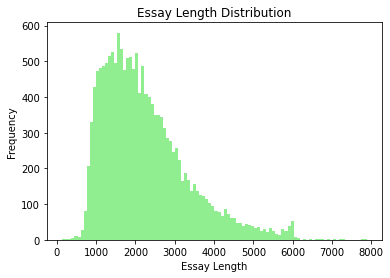

In [16]:
# full text length
full_text_length = train['full_text'].drop_duplicates().apply(len) # a pandas series
full_text_length.plot(kind='hist', bins=100, color = 'lightgreen')
plt.title('Essay Length Distribution')
plt.xlabel("Essay Length")
plt.ylabel("Frequency");

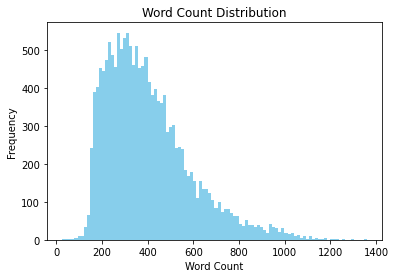

In [17]:
word_count = train['full_text'].drop_duplicates().apply(lambda x: len(str(x).split()))
word_count.plot(kind='hist', bins=100, color = 'skyblue')
plt.title('Word Count Distribution')
plt.xlabel("Word Count")
plt.ylabel("Frequency");

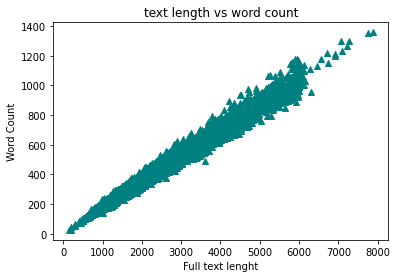

In [18]:
plt.scatter(full_text_length, word_count, marker='^', color = 'teal')
plt.title("text length vs word count")
plt.xlabel('Full text lenght')
plt.ylabel('Word Count');

# Color Text

In [19]:
colors = {
            'Lead': '#8000ff',
            'Position': '#2b7ff6',
            'Evidence': '#2adddd',
            'Claim': '#80ffb4',
            'Concluding Statement': 'd4dd80',
            'Counterclaim': '#ff8042',
            'Rebuttal': '#ff0000'
         }

def read_essay(id):
    with open(f"../input/feedback-prize-2021/train/{id}.txt") as f:
        essay = f.read()
    return essay


def visualize(example):
    ents = []
    for i, row in train[train['id'] == example].iterrows():
        ents.append({
                        'start': int(row['discourse_start']), 
                         'end': int(row['discourse_end']), 
                         'label': row['discourse_type']
                    })

    data = read_essay(example)

    doc2 = {
        "text": data,
        "ents": ents,
        "title": example
    }

    options = {"ents": train.discourse_type.unique().tolist(), "colors": colors}
    displacy.render(doc2, style="ent", options=options, manual=True, jupyter=True)

visualize("423A1CA112E2")

# Ngram

In [20]:
def get_top_n_words(corpus, n=None, remove_stop_words=False, n_words=1): 
    
    if remove_stop_words:
        vec = CountVectorizer(stop_words = 'english', ngram_range=(n_words, n_words)).fit(corpus)
    else:
        vec = CountVectorizer(ngram_range=(n_words, n_words)).fit(corpus)
        
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

### Unigrams

In [21]:
common_words = get_top_n_words(train['full_text'].drop_duplicates(), 20, remove_stop_words=True, n_words=1)
for word, freq in common_words:
    print(word, freq)

students 52028
people 43273
school 32397
help 21639
like 20340
time 19818
just 19384
make 19195
car 18862
cars 18262
think 17292
student 16744
work 14427
electoral 14427
good 13536
college 13275
better 13147
want 13037
know 13018
way 12961


### Bigrams

In [22]:
common_words = get_top_n_words(train['full_text'].drop_duplicates(), 20, remove_stop_words=True, n_words=2)
for word, freq in common_words:
    print(word, freq)

electoral college 11136
driverless cars 5631
cell phones 3819
community service 3671
popular vote 3207
online classes 2840
distance learning 2642
summer projects 2433
classes home 2375
united states 2247
cell phone 2194
multiple people 2178
student designed 1937
driverless car 1889
extracurricular activities 1797
face mars 1762
vote president 1714
multiple opinions 1681
car usage 1667
extracurricular activity 1631


### Trigrams

In [23]:
common_words = get_top_n_words(train['full_text'].drop_duplicates(), 20, remove_stop_words=True, n_words=3)
for word, freq in common_words:
    print(word, freq)

facial action coding 1174
attend classes home 1069
limiting car usage 871
use cell phones 809
make better choice 749
help make better 745
electoral college unfair 736
seeking multiple opinions 651
election popular vote 578
student designed projects 565
able attend classes 564
cell phones school 548
ask multiple people 539
online video conferencing 534
seagoing cowboys program 522
projects student designed 515
multiple people advice 503
asking multiple people 502
car free day 500
venus worthy pursuit 499


# Wordcloud

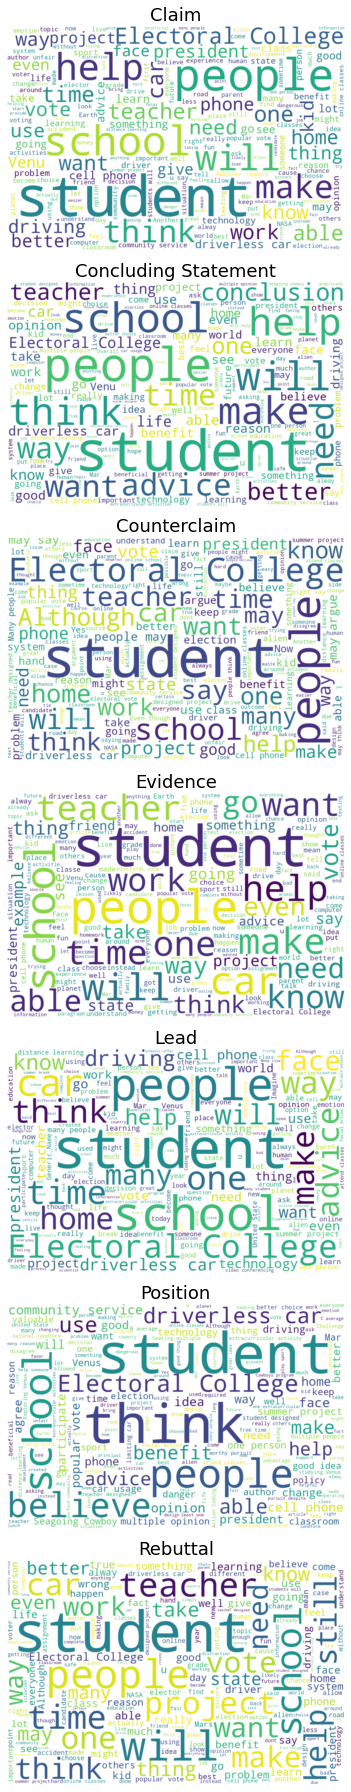

In [24]:
# wordcloud with respect to discourse type
fig, axs = plt.subplots(7, 1, figsize=(20, 25))

plt_idx = 0

for discourse_type, d in train.groupby("discourse_type"):
    discourse_text = " ".join(d["discourse_text"].values.tolist())
    wordcloud = WordCloud(
        max_font_size=200,
        max_words=200,
        width=1200,
        height=800,
        background_color="white",
    ).generate(discourse_text)
    axs = axs.flatten()
    axs[plt_idx].imshow(wordcloud, interpolation="bilinear")
    axs[plt_idx].set_title(discourse_type, fontsize=18)
    axs[plt_idx].axis("off")
    plt_idx += 1
plt.tight_layout()
plt.show()

## If you find it helpful, please consider upvotting. Thank You